In [1]:
# Sources 
# https://github.com/tobikuhlmann/credit-risk-classification/blob/master/germancredit.ipynb
# https://www.kaggle.com/hendraherviawan/predicting-german-credit-default

# enable inline plotting with matplotbib and seaborn
%matplotlib inline

import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import pydotplus 

from IPython.display import Image  
from collections import defaultdict
from sklearn.dummy import DummyClassifier
from sklearn import svm, tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.feature_selection import RFE, SelectKBest, chi2, SelectFromModel
from sklearn.linear_model import LogisticRegression, SGDClassifier
from imblearn.over_sampling import SMOTE

In [2]:
datafile = pd.read_csv('Credit-Risk-Score-Dataset.csv')

In [3]:
datafile.head()

Unnamed: 0   V1  V2   V3   V4    V5   V6   V7  V8   V9  ...   V12  V13  \
0           1  A11   6  A34  A43  1169  A65  A75   4  A93  ...  A121   67   
1           2  A12  48  A32  A43  5951  A61  A73   2  A92  ...  A121   22   
2           3  A14  12  A34  A46  2096  A61  A74   2  A93  ...  A121   49   
3           4  A11  42  A32  A42  7882  A61  A74   2  A93  ...  A122   45   
4           5  A11  24  A33  A40  4870  A61  A73   3  A93  ...  A124   53   

    V14   V15 V16   V17   V18   V19   V20 V21  
0  A143  A152   2  A173  good  A192  A201   1  
1  A143  A152   1  A173  good  A191  A201   2  
2  A143  A152   1  A172   bad  A191  A201   1  
3  A143  A153   1  A173   bad  A191  A201   1  
4  A143  A153   2  A173   bad  A191  A201   2  

[5 rows x 22 columns]

In [4]:
datafile = datafile.iloc[:, 1:]
datafile.shape

(1000, 21)

In [5]:
datafile.rename(columns = {'V1': 'cheque_account','V2': 'duration', 'V3': 'credit_history', 'V4': 'purpose', 'V5': 'amount', 'V6': 'savings_account', 'V7': 'current_employment', 'V8': 'installment_rate', 'V9': 'gender', 'V10': 'other_debtor', 'V11': 'current_residence', 'V12': 'property', 'V13': 'age', 'V14': 'other_installments', 'V15': 'housing', 'V16': 'number_of_credits', 'V17': 'occupation', 'V18': 'number_of_people', 'V19': 'contact_number', 'V20': 'foreign', 'V21': 'response'} , inplace = True)

In [6]:
datafile.head()

cheque_account  duration credit_history purpose  amount savings_account  \
0            A11         6            A34     A43    1169             A65   
1            A12        48            A32     A43    5951             A61   
2            A14        12            A34     A46    2096             A61   
3            A11        42            A32     A42    7882             A61   
4            A11        24            A33     A40    4870             A61   

  current_employment  installment_rate gender other_debtor  ...  property age  \
0                A75                 4    A93         A101  ...      A121  67   
1                A73                 2    A92         A101  ...      A121  22   
2                A74                 2    A93         A101  ...      A121  49   
3                A74                 2    A93         A103  ...      A122  45   
4                A73                 3    A93         A101  ...      A124  53   

   other_installments housing number_of_credits  occupation number_of_people  \
0                A143    A152                 2        A173             good   
1                A143    A152                 1        A173             good   
2                A143    A152                 1        A172              bad   
3                A143    A153                 1        A173              bad   
4                A143    A153                 2        A173              bad   

  contact_number foreign response  
0           A192    A201        1  
1           A191    A201        2  
2           A191    A201        1  
3           A191    A201        1  
4           A191    A201        2  

[5 rows x 21 columns]

In [7]:
# Subtracting 1 from each row in the 'response' column . 

datafile['response'] = datafile['response'] - 1
datafile.response.value_counts()

0    700
1    300
Name: response, dtype: int64

In [8]:
# Sorting data into Categorical and Numerical variable labels

catVariables = ['cheque_account', 'credit_history', 'purpose', 'savings_account', 'current_employment', 'gender', 'other_debtor', 'property', 'other_installments', 'housing', 'occupation', 'number_of_people', 'contact_number', 'foreign']

numVariables = ['duration', 'amount', 'installment_rate', 'current_residence', 'age', 'number_of_credits', 'response']

In [9]:
print(datafile.isnull().sum().sum())

0


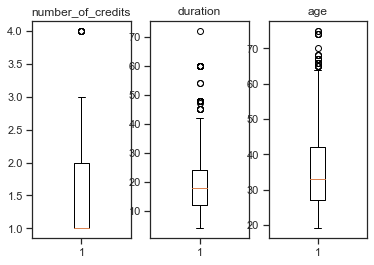

In [10]:
# Boxplots for continuous attributes
fig, axes = plt.subplots(nrows = 1, ncols = 3)
axes[0].boxplot(datafile['number_of_credits'])
axes[0].set_title('number_of_credits')
axes[1].boxplot(datafile['duration'])
axes[1].set_title('duration')
axes[2].boxplot(datafile['age'])
axes[2].set_title('age')

fig.savefig("boxplots.png")

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


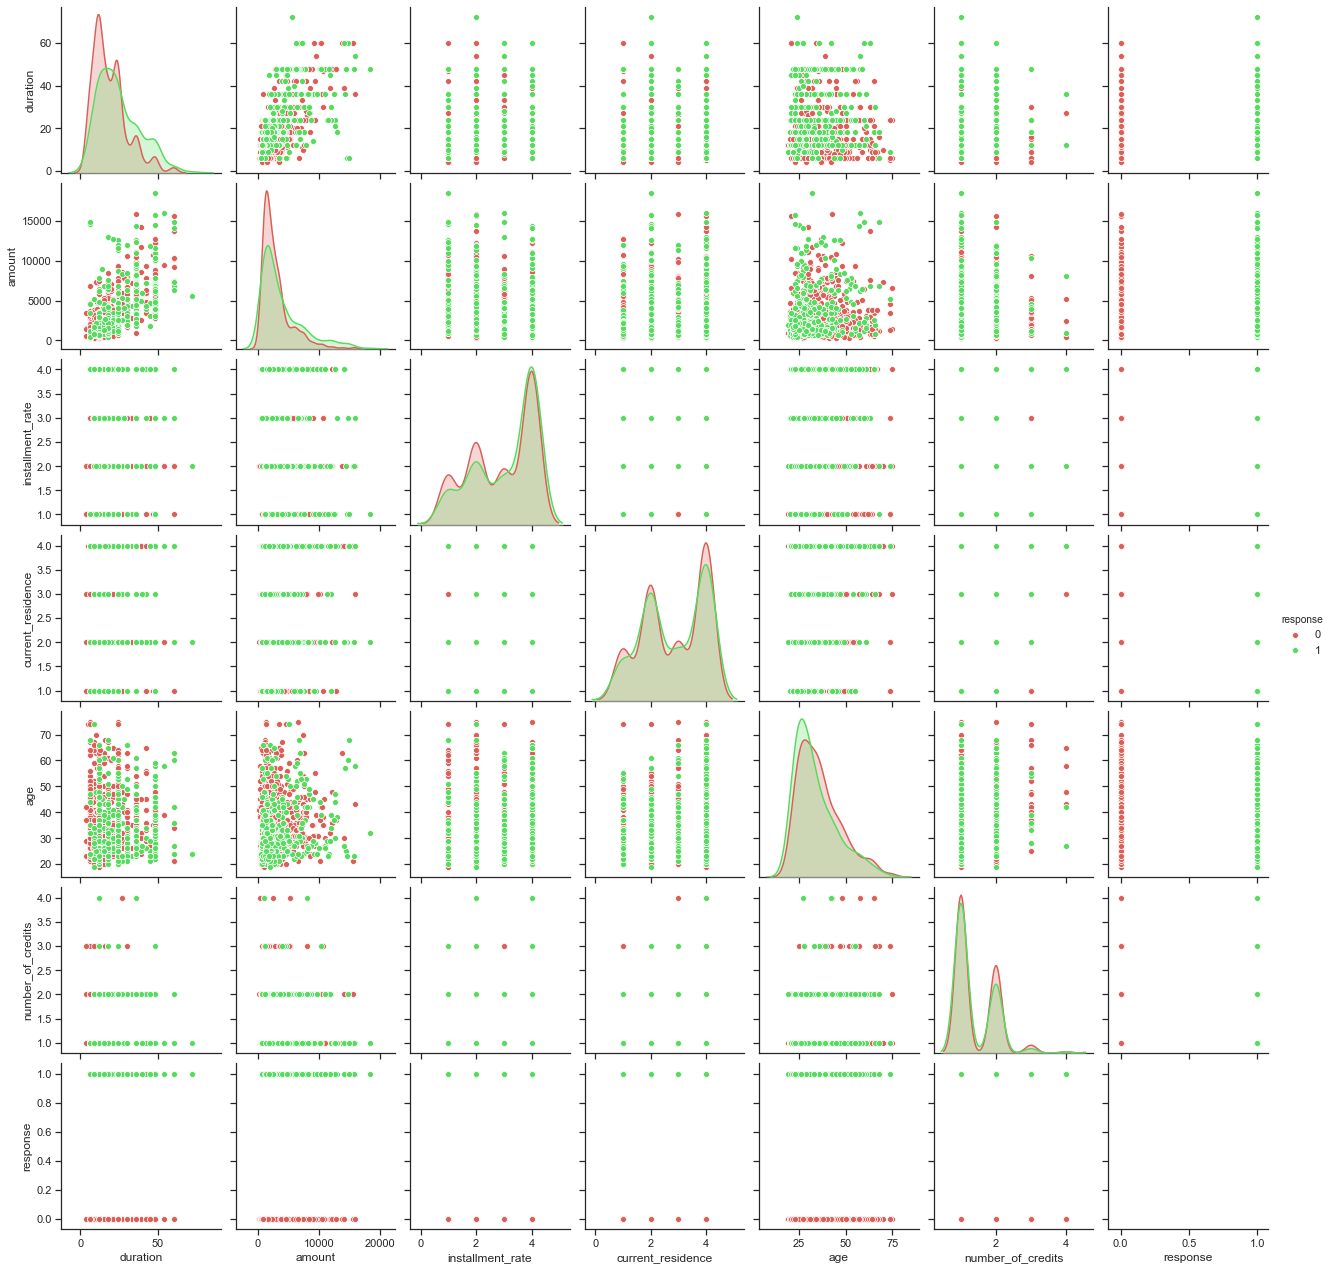

In [11]:

response = datafile.response.value_counts()
var = numVariables

sns.pairplot(datafile, vars = var, hue = 'response', palette = sns.color_palette("hls", 3))

In [12]:
# Numerical features range of values

for x in range(len(numVariables)):
    print(numVariables[x],": ", datafile[numVariables[x]].min()," - ",datafile[numVariables[x]].max())

duration :  4  -  72
amount :  250  -  18424
installment_rate :  1  -  4
current_residence :  1  -  4
age :  19  -  75
number_of_credits :  1  -  4
response :  0  -  1


In [13]:
# Evaluation Metrics Function 

def get_eval(clf, X_train, y_train, y_test, y_pred):
    
    # cross validation to test and anticipate overfitting problem
    
    scores1 = cross_val_score(clf, X_train, y_train, cv = 10, scoring = 'accuracy')
    scores2 = cross_val_score(clf, X_train, y_train, cv = 10, scoring = 'precision')
    scores3 = cross_val_score(clf, X_train, y_train, cv = 10, scoring = 'roc_auc')
    
    # Mean score and standard deviation of score estimates
    
    print('Cross Validation Accuracy: %0.2f (+/- %0.2f)' % (scores1.mean(), scores1.std()))
    print('Cross Validation Precision: %0.2f (+/- %0.2f)' % (scores2.mean(), scores2.std()))
    print('Cross Validation roc_auc: %0.2f (+/- %0.2f)' % (scores3.mean(), scores3.std()))
    
    # Confusion Matrix
    abclf_cm = confusion_matrix(y_test, y_pred)
    print(abclf_cm)
    return

# roc curve function
def get_roc(y_test, y_pred):
    
    # compute ROC curve and ROC area for each class
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr , _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # plotting ROC curve
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color = 'darkorange', label = 'ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0,1], [0,1], color = 'navy', lw = lw, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.1, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Posituve Rate')
    plt.title('Receiver Operating Characristic')
    plt.legend(loc = 'lower right')
    plt.show()
    return

In [14]:
# fit, train and cross validation : Decision Tree

def decisionTreeClf(X_train, y_train, X_test, y_test):
    print('DecisionTreeClassifier')
    
    decisionTree = tree.DecisionTreeClassifier(min_samples_split = 10, min_samples_leaf = 5).fit(X_train, y_train)
     
    y_pred = decisionTree.predict(X_test)
        
        # Export visualization as file
        # visualize_tree(decisionTree,X_train,y_train)
        
        # Cross validation and confusion matrix
    get_eval(decisionTree, X_train, y_train, y_test, y_pred)
    return
    
# Visualize tree and save as .pdf
# Only works for dataframes, not for numpy arrays
def visialize_tree(clf, X_train, y_train):
    plot_data = export_graphviz(clf, out_file = None)
    graph = pydotplus.graph_from_dot_data(plot_data)
    graph.write_pdf('decisionTree.pdf')
    
    plot_data = export_graphviz(clf, out_file = None, feature_name = [str(x) for x in X_train.column.tolist()],
                               
                                # feature names from X_train column names
                                
                                class_names = [str(x) for x in clf.classes_],
                                filled = True, rounded = True, special_characters = True, leaves_paralled = True)
    
    graph = pydotplus.graph_from_dot_data(plot_data)
    Image(graph.create_png())
    return

In [15]:
# Random Forest Classifier

def randomForestClf(X_train, y_train, X_test, y_test):
    print('RandomForestClassifier')
    randomforest = RadomForestClassifier().fit(X_train, y_train)
    
    # Predict target variables y for test data
    y_pred = randomforest.predict(X_test)
    
    #Cross Validation and Confusion Matrix
    get_eval(randomforest, X_train, y_train, y_test, y_pred)
    return

In [16]:
# Logistic Regression

def logregClf(X_train, y_train,X_test, y_test):
    print("LogisticRegression")
    logreg = LogisticRegression().fit(X_train, y_train)

    # Predict target variables y for test data
    y_pred = logreg.predict(X_test)

    # Get Cross Validation and Confusion matrix
    get_eval(logreg, X_train, y_train,y_test,y_pred)
    return

In [17]:
# Neural Network: MLPClassifier

def MLPClf(X_train, y_train, X_test, y_test):
    print('MLPClassifier')
    
    mlpclf = MLPClassifier(solver = 'lbfgs', alpha = 5, hidden_layer_size = (75, 75))
    mlpclf.fit(X_train, y_train)
    
    print(mlpclf.get_params)
    
    # Predict target variables y for test data
    y_pred = mlpclf.predict(X_test)
    
    # Cross validation and confusion matrix
    get_eval(mlpclf, X_train, y_train, y_train, y_pred)
    return

In [18]:
# Labelencoding to transform categorical to numerical
# Enables better Visualization than one hot encoding
d = defaultdict(LabelEncoder)

# Encoding the variable
lecatdata = datafile[catVariables].apply(lambda x: d[x.name].fit_transform(x))

# print transformations
for x in range(len(catVariables)):
    print(catVariables[x],": ", datafile[catVariables[x]].unique())
    print(catVariables[x],": ", lecatdata[catVariables[x]].unique())

cheque_account :  ['A11' 'A12' 'A14' 'A13']
cheque_account :  [0 1 3 2]
credit_history :  ['A34' 'A32' 'A33' 'A30' 'A31']
credit_history :  [4 2 3 0 1]
purpose :  ['A43' 'A46' 'A42' 'A40' 'A41' 'A49' 'A44' 'A45' 'A410' 'A48']
purpose :  [4 7 3 0 1 9 5 6 2 8]
savings_account :  ['A65' 'A61' 'A63' 'A64' 'A62']
savings_account :  [4 0 2 3 1]
current_employment :  ['A75' 'A73' 'A74' 'A71' 'A72']
current_employment :  [4 2 3 0 1]
gender :  ['A93' 'A92' 'A91' 'A94']
gender :  [2 1 0 3]
other_debtor :  ['A101' 'A103' 'A102']
other_debtor :  [0 2 1]
property :  ['A121' 'A122' 'A124' 'A123']
property :  [0 1 3 2]
other_installments :  ['A143' 'A141' 'A142']
other_installments :  [2 0 1]
housing :  ['A152' 'A153' 'A151']
housing :  [1 2 0]
occupation :  ['A173' 'A172' 'A174' 'A171']
occupation :  [2 1 3 0]
number_of_people :  ['good' 'bad']
number_of_people :  [1 0]
contact_number :  ['A192' 'A191']
contact_number :  [1 0]
foreign :  ['A201' 'A202']
foreign :  [0 1]


In [19]:

# Standardization
numdata_std = pd.DataFrame(StandardScaler().fit_transform(datafile[numVariables].drop(['response'], axis = 1)))
# MinMax Rescaling to [0,1]
numdata_minmax = pd.DataFrame(MinMaxScaler().fit_transform(datafile[numVariables].drop(['response'], axis = 1)))
print("success")

success


In [20]:
# One hot encoding
#create dummy variables for every category of every categorical variable
dummyvars = pd.get_dummies(datafile[catVariables])

In [21]:
# append the dummy variable of the initial numerical variables numvars
data_clean = pd.concat([datafile[numVariables], dummyvars], axis = 1)
data_std = pd.concat([numdata_std, datafile['response'], dummyvars], axis = 1)
data_minmax = pd.concat([numdata_minmax, datafile['response'], dummyvars], axis = 1)
print(data_clean.shape)
print(data_std.shape)
print(data_minmax.shape)

(1000, 63)
(1000, 63)
(1000, 63)


In [22]:
# Split Training and Test Data


# Unscaled, unnormalized data
X_clean = data_clean.drop('response', axis=1)
y_clean = data_clean['response']
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean,y_clean,test_size=0.3333, random_state=1)

# Standardized data
X_std = data_std.drop('response', axis=1)
y_std = data_std['response']
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_std,y_std,test_size=0.3333, random_state=1)

# Rescaled data
X_minmax = data_minmax.drop('response', axis=1)
y_minmax = data_minmax['response']
X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax = train_test_split(X_minmax,y_minmax,test_size=0.3333, random_state=1)

In [23]:
# Apply SMOTE

sm = SMOTE(sampling_strategy = 'auto')
X_train_clean_res, y_train_clean_res = sm.fit_resample(X_train_clean, y_train_clean)
X_train_std_res, y_train_std_res = sm.fit_resample(X_train_std, y_train_std)
X_train_minmax_res, y_train_minmax_res = sm.fit_resample(X_train_minmax, y_train_minmax)

# Print number of 'good' credits and 'bad credits, should be fairly balanced now
print("Before/After clean")
unique, counts = np.unique(y_train_clean, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_train_clean_res, return_counts=True)
print(dict(zip(unique, counts)))
print("Before/After std")
unique, counts = np.unique(y_train_std, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_train_std_res, return_counts=True)
print(dict(zip(unique, counts)))
print("Before/After minmax")
unique, counts = np.unique(y_train_minmax, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_train_minmax_res, return_counts=True)
print(dict(zip(unique, counts)))

Before/After clean
{0: 458, 1: 208}
{0: 458, 1: 458}
Before/After std
{0: 458, 1: 208}
{0: 458, 1: 458}
Before/After minmax
{0: 458, 1: 208}
{0: 458, 1: 458}


In [24]:
# Classification to evaluate data transformation
# Unbalanced data: Balance dataset, adjust cost function of algo, adjusting class weights
# General: adjust loss function


# Dummy Classifier
print("DummyClassifier")
dclf = DummyClassifier(strategy='stratified').fit(X_train_clean, y_train_clean)

# Predict target variables y for test data
y_pred = dclf.predict(X_test_clean)

# Get Cross Validation and Confusion matrix
get_eval(dclf, X_train_clean, y_train_clean,y_test_clean,y_pred)


DummyClassifier
Cross Validation Accuracy: 0.56 (+/- 0.04)
Cross Validation Precision: 0.31 (+/- 0.10)
Cross Validation roc_auc: 0.50 (+/- 0.06)
[[168  74]
 [ 64  28]]


In [25]:
# Decisiontree
# Train, test and evaluate the classifiers with different preprocessed data
print("clean resampled")
decisionTreeClf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

clean resampled
DecisionTreeClassifier
Cross Validation Accuracy: 0.75 (+/- 0.12)
Cross Validation Precision: 0.73 (+/- 0.09)
Cross Validation roc_auc: 0.80 (+/- 0.14)
[[199  43]
 [ 48  44]]


In [26]:
# Data Reduction
# Feature Selection 
# Save Correlation Matrix of every variable
data_clean.corr( method = 'pearson').to_csv("credit-score-data-corr.csv")

# List highly correlated features
c = data_clean.corr()
# Pivots the row/class labels with respective values: matrix -> list
s = c.stack()
# Select and sort (descending) all pairs with correlation values 0.5<x<1 or -1<x<-0.5
so = s[(0.5<s) & (s<1) | (-1<s) & (s<-0.5)].sort_values(ascending=False, kind='quicksort')
print(so)

property_A124            housing_A153               0.779853
housing_A153             property_A124              0.779853
duration                 amount                     0.624984
amount                   duration                   0.624984
number_of_credits        credit_history_A34         0.501364
credit_history_A34       number_of_credits          0.501364
number_of_credits        credit_history_A32        -0.540354
credit_history_A32       number_of_credits         -0.540354
occupation_A173          occupation_A174           -0.543852
occupation_A174          occupation_A173           -0.543852
housing_A153             housing_A152              -0.548445
housing_A152             housing_A153              -0.548445
savings_account_A61      savings_account_A65       -0.583281
savings_account_A65      savings_account_A61       -0.583281
other_debtor_A102        other_debtor_A101         -0.645721
other_debtor_A101        other_debtor_A102         -0.645721
occupation_A173         

In [27]:

# SelectKBest
# Use rescaled data, as data must be non-negative
skb = SelectKBest(chi2, k=50)
skb.fit(X_train_minmax_res, y_train_minmax_res)

# Apply fitted transformation to datasets
SKBX_train = skb.transform(X_train_clean_res)
SKBX_test = skb.transform(X_test_clean)
SKBy_train = y_train_minmax_res
SKBy_test = y_test_minmax

In [28]:
# Recursive feature elimination (RFE)
# Use clean data, as logistic regression should be robust do different feature scales
rfe = RFE(LogisticRegression(), 50)
fit = rfe.fit(X_train_clean_res, y_train_clean_res)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

# Apply fitted transformation to datasets
RFEX_train = rfe.transform(X_train_clean_res)
RFEX_test = rfe.transform(X_test_clean)
RFEy_train = y_train_clean_res
RFEy_test = y_test_clean

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_features_to_select=50 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase 

In [29]:
# Bagged Decision Trees like Random Forest and Extra Tree to determine feature importance
# Use clean data, unstandardized and unscaled, because tree is robust to different scales
etcclf = ExtraTreesClassifier().fit(X_train_clean_res, y_train_clean_res)
    
# Select important features using sklearn SelectFromModel, vary treshold, good value turns out to be mean -> select overaverage important features
sfm = SelectFromModel(etcclf, prefit=True, threshold=0.01)

# Apply fitted transformation to datasets
SFMETCX_train = sfm.transform(X_train_clean_res)
SFMETCX_test = sfm.transform(X_test_clean)
SFMETCy_train = y_train_clean_res
SFMETCy_test = y_test_clean

# Print shape to see how many features have been selected
print(SFMETCX_train.shape)

# Calculate the feature ranking - Top50 
importances = etcclf.feature_importances_ 
std = np.std([etcclf.feature_importances_ for tree in etcclf.estimators_], axis=0) 
indices = np.argsort(importances)[::-1] 
print("Top 50 Features:") 
for f in range(50): 
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

(916, 42)
Top 50 Features:
1. feature 9 (0.092476)
2. feature 14 (0.062728)
3. feature 0 (0.033682)
4. feature 1 (0.032408)
5. feature 29 (0.032198)
6. feature 42 (0.031815)
7. feature 50 (0.027995)
8. feature 4 (0.027511)
9. feature 19 (0.026642)
10. feature 2 (0.025058)
11. feature 48 (0.022819)
12. feature 12 (0.022345)
13. feature 3 (0.022327)
14. feature 37 (0.021535)
15. feature 59 (0.021062)
16. feature 6 (0.020154)
17. feature 16 (0.019180)
18. feature 32 (0.018689)
19. feature 33 (0.018459)
20. feature 18 (0.017868)
21. feature 7 (0.017867)
22. feature 34 (0.017736)
23. feature 8 (0.016999)
24. feature 54 (0.016998)
25. feature 36 (0.016655)
26. feature 28 (0.014535)
27. feature 58 (0.014485)
28. feature 44 (0.014461)
29. feature 43 (0.014345)
30. feature 25 (0.014219)
31. feature 15 (0.013698)
32. feature 5 (0.013405)
33. feature 55 (0.012277)
34. feature 31 (0.011631)
35. feature 53 (0.011366)
36. feature 13 (0.011182)
37. feature 46 (0.011137)
38. feature 38 (0.011126)
39. 

In [30]:
# Principal Component Analysis
# Here we use standardized data, to not overestimate the influence of single variables, which results from different scaling
pca = PCA(n_components=10)
pca.fit_transform(X_train_std_res, y_train_std_res)
print(pca.explained_variance_ratio_) 

# Apply fitted transformation to datasets
PCAX_train = pca.transform(X_train_clean_res)
PCAX_test = pca.transform(X_test_clean)
PCAy_train = y_train_std_res
PCAy_test = y_test_std

[0.15460532 0.11279056 0.08636911 0.07411347 0.06593051 0.03607382
 0.03308869 0.03102346 0.0266448  0.02554229]


In [31]:
# Classification to evaluate data reduction


# Logistic Regression
# clean res data and different data reduction
print("without reduction")
logregClf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)
print("SKB")
logregClf(SKBX_train, SKBy_train, SKBX_test, SKBy_test)
print("RFE")
logregClf(RFEX_train, RFEy_train, RFEX_test, RFEy_test)
print("SFMETC")
logregClf(SFMETCX_train, SFMETCy_train, SFMETCX_test, SFMETCy_test)
print("PCA")
logregClf(PCAX_train, PCAy_train, PCAX_test, PCAy_test)

gression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://s